In [1]:
from scipy import io
from pathlib import Path

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import optax

from collections import defaultdict
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import CircHMM
from dynamax.utils.plotting import gradient_cmap

from functools import partial
from jax import vmap

I0000 00:00:1727444632.471678 1842471 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
num_train_batches = 80
num_test_batches = 20
num_timesteps = 20

key = jr.PRNGKey(1)

# Make an HMM and sample data and true underlying states
true_num_states = 5
input_dim = 2
emission_dim = 1
hmm = CircHMM(true_num_states, input_dim, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states

transition_weights = 1 * jr.normal(key, (true_num_states, true_num_states, input_dim))

emission_weights = 0.1 * jr.normal(key, (true_num_states, emission_dim, input_dim))
emission_covs = jnp.tile(jnp.eye(emission_dim), (true_num_states, 1, 1)) * 50



In [3]:
initial_probs

Array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32)

In [4]:
transition_weights.shape
# transition_weights

(5, 5, 2)

In [5]:
stronger_diag = jnp.stack([jnp.zeros((true_num_states, true_num_states)), jnp.eye(true_num_states) * 3], axis=-1)
# stronger_diag

In [6]:
# transition_weights generator configuration
transition_weights_mod = transition_weights + stronger_diag
transition_weights_mod

Array([[[-0.76433897,  4.4304023 ],
        [ 0.29602233, -0.2620028 ],
        [ 0.7534696 ,  0.38421908],
        [ 1.3584293 ,  1.9853761 ],
        [-0.5374943 , -1.2144603 ]],

       [[ 1.1424834 ,  0.23388885],
        [-0.977204  ,  2.9880054 ],
        [ 0.6962024 ,  1.3386534 ],
        [ 0.35359615,  1.3369001 ],
        [ 1.3061655 , -1.6693078 ]],

       [[-0.12277574,  0.8758087 ],
        [-0.38047376, -0.8069952 ],
        [ 0.03505866,  3.1026542 ],
        [ 0.12381285, -1.1133257 ],
        [-0.19076478,  1.4280903 ]],

       [[-0.78696334,  1.7904425 ],
        [ 0.60417485, -0.29894122],
        [ 1.7950747 , -1.4379933 ],
        [ 2.10746   ,  2.9403543 ],
        [-1.8987111 , -0.5051671 ]],

       [[-0.56490016, -1.0505275 ],
        [ 0.39251304,  0.86643845],
        [ 1.1392976 , -0.3791278 ],
        [ 1.6222832 ,  0.1660295 ],
        [-0.08054032,  4.6325336 ]]], dtype=float32)

In [7]:
# distribute -pi to pi evenly in state range
offset = 0
state_range = (jnp.linspace(0.1, 1.6 * jnp.pi, true_num_states) + offset) % ( 2* jnp.pi) - jnp.pi
state_range

Array([-3.0415928 , -1.8099556 , -0.5783186 ,  0.65331864,  1.8849556 ],      dtype=float32)

(-3.141592653589793, 3.141592653589793)

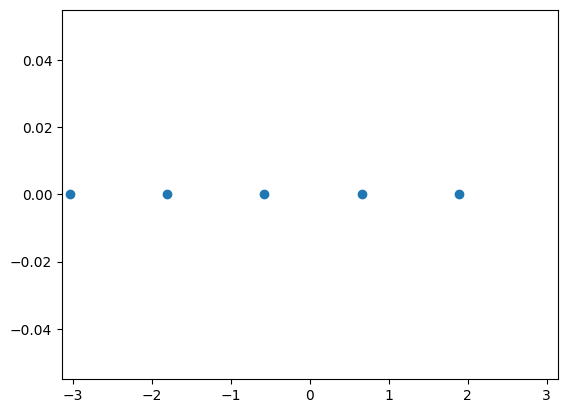

In [8]:
# plot this state range
plt.figure()
plt.plot(state_range, jnp.zeros_like(state_range), 'o')
plt.xlim(-jnp.pi, jnp.pi)

In [9]:
# emission_weights
emission_weights_mod = emission_weights.at[:, 0, 1].set(state_range)
emission_weights_mod

Array([[[ 0.0690805 , -3.0415928 ]],

       [[-0.1155789 , -1.8099556 ]],

       [[-0.01959843, -0.5783186 ]],

       [[ 0.09156866,  0.65331864]],

       [[-0.03674942,  1.8849556 ]]], dtype=float32)

In [10]:
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_weights=transition_weights_mod,
                                emission_weights=emission_weights_mod,
                                emission_covariances=emission_covs)

In [11]:
# choose from 0 to 1 randomly num_timesteps times
first_input = jr.uniform(key, (num_train_batches, num_timesteps,1))
intercept = jnp.ones((num_train_batches, num_timesteps, 1))

inputs_batch_train = jnp.concatenate([first_input, intercept], axis=-1)


# do for the test batch
first_input = jr.uniform(key, (num_test_batches, num_timesteps,1))
intercept = jnp.ones((num_test_batches, num_timesteps, 1))

inputs_batch_test = jnp.concatenate([first_input, intercept], axis=-1)

inputs_batch_train.shape, inputs_batch_test.shape

((80, 20, 2), (20, 20, 2))

In [12]:
# # Sample train, validation, and test data
# train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
# f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps, inputs=jnp.ones((num_timesteps, input_dim))))
# train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
# test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))

In [37]:
# # Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)

# Split keys for each batch
train_keys = jr.split(train_key, num_train_batches)

# Sample by indexing the input for each batch outside the function
train_true_states, train_emissions = [], []
for i in range(num_train_batches):
    true_states, emissions = hmm.sample(true_params, num_timesteps=num_timesteps, inputs=inputs_batch_train[i], key=train_keys[i])
    train_true_states.append(true_states)
    train_emissions.append(emissions)

# Convert lists to jax arrays
train_true_states = jnp.array(train_true_states)
train_emissions = jnp.array(train_emissions)

# Similarly for test data
test_keys = jr.split(test_key, num_test_batches)
test_true_states, test_emissions = [], []
for i in range(num_test_batches):
    true_states, emissions = hmm.sample(true_params, num_timesteps=num_timesteps, inputs=inputs_batch_test[i], key=test_keys[i])
    test_true_states.append(true_states)
    test_emissions.append(emissions)

test_true_states = jnp.array(test_true_states)
test_emissions = jnp.array(test_emissions)

In [38]:
train_emissions.shape

(80, 20, 1, 1)

In [39]:
train_emissions.reshape(80,20)[:5, :3]

Array([[ 1.7999133 ,  2.0399837 ,  1.9671775 ],
       [-0.56344867, -0.6033572 ,  1.7276726 ],
       [-1.9712641 ,  0.8270781 ,  2.0297892 ],
       [ 1.7224189 ,  1.9227799 ,  2.1529088 ],
       [-0.42788813, -3.0859756 , -2.7703147 ]], dtype=float32)

In [40]:
train_true_states.reshape(80,20)[:5, :3]

Array([[4, 4, 4],
       [2, 2, 4],
       [1, 3, 4],
       [4, 4, 4],
       [2, 0, 0]], dtype=int32)

In [41]:
train_true_states.shape

(80, 20)

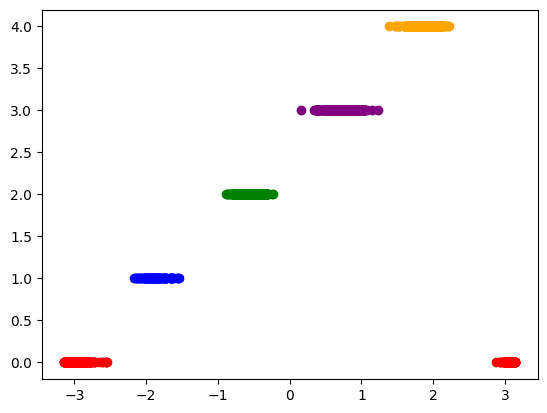

In [42]:
# visualize train data
# train_emissions.reshape(10,100)[0]

# to visualize:
# emm = train_emissions.reshape(num_train_batches,num_timesteps)[1]
# tr = train_true_states.reshape(num_train_batches,num_timesteps)[1]

emm = train_emissions.reshape(-1)
tr = train_true_states.reshape(-1)

# emissions are radians, so plot them on the number line and color by state
fig, ax = plt.subplots()
for i in range(5):
    ax.scatter(emm[tr==i], tr[tr==i], color=["red", "blue", "green", "purple", "orange"][i])
plt.show()


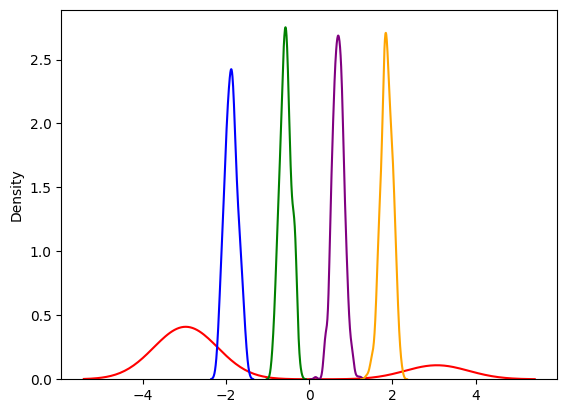

In [43]:
# using the tr as labels, plot the distribution of emm for each state
fig, ax = plt.subplots()
for i in range(5):
    sns.kdeplot(emm[tr==i], color=["red", "blue", "green", "purple", "orange"][i], ax=ax)
plt.show()


In [44]:
train_emissions.shape, inputs_batch_train.shape

((80, 20, 1, 1), (80, 20, 2))

In [45]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = CircHMM(5, input_dim, emission_dim)
params, props = test_hmm.initialize(key=key)
params, lps = test_hmm.fit_sgd( params = params, 
                                props = props, 
                                emissions = train_emissions.reshape(num_train_batches,num_timesteps,1), 
                                inputs = inputs_batch_train, 
                                num_epochs = 5000, 
                                optimizer = optax.adam(1e-3), 
                                shuffle = False,
                                batch_size = 8)

In [46]:
lps

Array([ 1.9346794 ,  1.9228525 ,  1.9116592 , ..., -0.0179133 ,
       -0.01791378, -0.01791415], dtype=float32)

In [47]:
train_true_states.shape

(80, 20)

In [48]:
# make test hmm predict the most linekly states for the train_emissions
predicted_train_states = []
for i in range(num_train_batches): predicted_train_states.append(test_hmm.most_likely_states(params, train_emissions.reshape(num_train_batches,num_timesteps,1)[i], inputs_batch_train[i]))
predicted_train_states = np.array(predicted_train_states)

In [56]:
inputs_batch_train.shape, train_emissions.shape

((80, 20, 2), (80, 20, 1, 1))

In [49]:
train_true_states

Array([[4, 4, 4, ..., 3, 3, 3],
       [2, 2, 4, ..., 0, 0, 0],
       [1, 3, 4, ..., 4, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [2, 2, 1, ..., 3, 0, 0],
       [4, 4, 4, ..., 4, 4, 4]], dtype=int32)

In [50]:
predicted_train_states

array([[3, 3, 3, ..., 0, 0, 0],
       [2, 2, 3, ..., 4, 4, 4],
       [4, 1, 3, ..., 3, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 2, 4, ..., 0, 4, 4],
       [4, 4, 4, ..., 3, 3, 3]], dtype=int32)

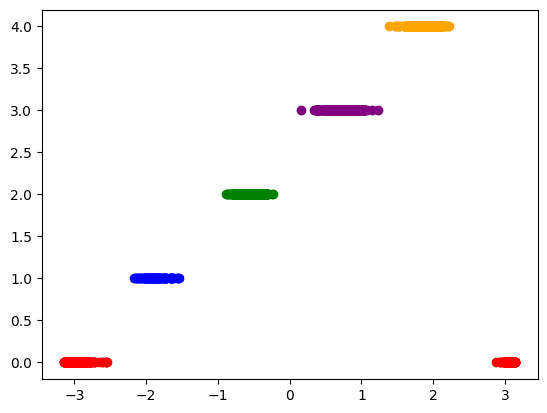

In [51]:
# train_emissions.reshape(10,100)[0]

# to visualize:
emm = train_emissions
tr = train_true_states

# emissions are radians, so plot them on the number line and color by state
fig, ax = plt.subplots()
for i in range(5):
    ax.scatter(emm[tr==i], tr[tr==i], color=["red", "blue", "green", "purple", "orange"][i])
plt.show()


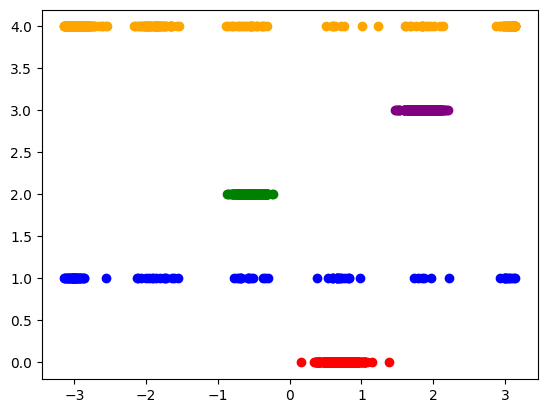

In [52]:
# train_emissions.reshape(10,100)[0]

# to visualize:
emm = train_emissions
tr = predicted_train_states

# emissions are radians, so plot them on the number line and color by state
fig, ax = plt.subplots()
for i in range(5):
    ax.scatter(emm[tr==i], tr[tr==i], color=["red", "blue", "green", "purple", "orange"][i])
plt.show()


In [57]:
params.emissions

ParamsCircEmissions(weights=Array([[[ 1.2036087e-03,  6.9784826e-01]],

       [[-1.9889466e+00, -5.3734064e-01]],

       [[-1.3594960e-01, -4.5982715e-01]],

       [[-9.5200971e-02,  1.9052734e+00]],

       [[ 9.4084209e-03, -2.7081876e+00]]], dtype=float32), covs=Array([[[43.507515 ]],

       [[ 1.2963858]],

       [[95.080986 ]],

       [[46.825867 ]],

       [[ 4.391645 ]]], dtype=float32))

In [59]:
params.transitions

ParamsCircHMMTransitions(transition_weights=Array([[[  5.201272  ,   6.6077924 ],
        [ -5.2665725 , -10.283406  ],
        [ -4.626707  , -10.171854  ],
        [ -5.2387886 , -10.3169775 ],
        [  0.05970363,   5.925474  ]],

       [[ 45.412746  , -12.619491  ],
        [ -3.5158274 , -11.564228  ],
        [-44.221775  ,  13.163435  ],
        [ -1.731528  ,   4.9167495 ],
        [ -7.7380137 , -10.312078  ]],

       [[ -7.024143  , -10.29201   ],
        [ -7.55875   , -10.42802   ],
        [ -1.8699553 ,   7.5391755 ],
        [  3.577636  ,   1.470324  ],
        [  7.0281568 ,  -1.5134386 ]],

       [[ -2.4849617 ,   4.198206  ],
        [ -8.05157   , -11.580108  ],
        [  6.391537  ,  -4.0004263 ],
        [ -2.94658   ,   7.1260495 ],
        [ -8.130544  , -11.735113  ]],

       [[ -1.2618259 ,  -8.304747  ],
        [  5.385241  ,   7.599416  ],
        [ -5.9455185 ,  -6.9125705 ],
        [ -2.6158676 ,  -8.062509  ],
        [  5.6951737 ,   8.683308  ]

In [95]:
t_tr, t_em = test_hmm.sample(params,key= key, num_timesteps=100, inputs=jnp.ones((100,1)))

In [96]:
t_tr.shape, t_em.shape

((100,), (100, 1, 1))

In [98]:
t_tr

Array([1, 4, 3, 4, 3, 0, 2, 3, 2, 2, 4, 2, 1, 3, 4, 0, 4, 3, 4, 3, 4, 2,
       1, 0, 4, 0, 1, 4, 3, 1, 4, 0, 0, 3, 4, 1, 3, 1, 1, 3, 3, 4, 3, 4,
       1, 1, 3, 1, 0, 0, 1, 4, 4, 1, 3, 4, 2, 1, 2, 1, 4, 3, 2, 3, 4, 1,
       2, 3, 4, 3, 1, 4, 3, 1, 0, 3, 2, 2, 4, 0, 2, 1, 4, 3, 0, 3, 3, 1,
       4, 4, 1, 1, 2, 3, 3, 1, 3, 4, 0, 1], dtype=int32)

In [102]:
t_em.shape

(100, 1, 1)

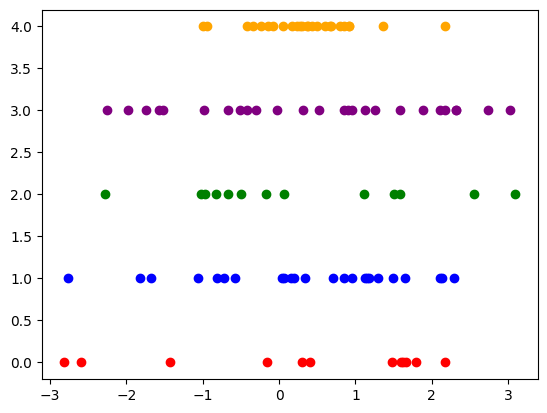

In [103]:
# train_emissions.reshape(10,100)[0]

# to visualize:
tr = t_tr.reshape(-1)
emm = t_em.reshape(-1)

# emissions are radians, so plot them on the number line and color by state
fig, ax = plt.subplots()
for i in range(5):
    ax.scatter(emm[tr==i], tr[tr==i], color=["red", "blue", "green", "purple", "orange"][i])
plt.show()


In [ ]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_sgd(params, 
                                              props, 
                                              y_train, 
                                              inputs=jnp.ones_like(y_train),
                                              num_epochs=num_iters)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

In [3]:
# Convert to radians
design_matrix[:,:,0] = np.deg2rad(design_matrix[:,:,0])
design_matrix[:,:,3] = np.deg2rad(design_matrix[:,:,3])

observation = np.deg2rad(observation)

# Add flat biases column
flat_biases = np.ones_like(design_matrix[:,:,:1])
design_matrix =  np.concatenate([design_matrix, flat_biases], axis=-1)

In [4]:
# Shuffle data
shuff_idx = np.random.permutation(len(design_matrix))

design_matrix = design_matrix[shuff_idx]
observation = observation[shuff_idx]

In [5]:
# Split it 80:20 for training and testing

train_idx = int(0.8 * len(design_matrix))

train_design = design_matrix[:train_idx]
train_obs = observation[:train_idx]

test_design = design_matrix[train_idx:]
test_obs = observation[train_idx:]

In [6]:
# convert to jax arrays
train_emissions = jnp.array(train_obs)
train_inputs = jnp.array(train_design)

In [7]:
# A training cache to store all the models and their parameters
training_cache = defaultdict(dict)

# DS to store the models organized
class Model_Store:
    n_states: int
    fit_model: None
    fit_params: None
    lps: None

In [8]:
def train_hmms(model_class, num_states, emission_dim, input_dim, train_emissions, train_inputs):
    
    model = model_class(num_states, input_dim, emission_dim)
    parameters, properties = model.initialize(key=jr.PRNGKey(1))

    # Fit with SGD
    fit_params, lps = model.fit_sgd(params = parameters, 
                                    props = properties, 
                                    emissions = train_emissions, 
                                    inputs = train_inputs, 
                                    num_epochs = 5000, 
                                    optimizer = optax.adam(1e-4), 
                                    shuffle = False, 
                                    batch_size = 32)
    
    return model, fit_params, lps

In [9]:
min_state, max_state = 2, 4
emission_dim, input_dim = 1, 5

for model_class in [CircHMM]:

    for num_states in range(min_state, max_state+1):
        print(f'Training: {model_class.__name__} - {num_states} states')

        model, fit_params, lps = train_hmms(model_class, num_states, emission_dim, input_dim, train_emissions, train_inputs)

        print(f"{lps[:10]}")

        t_store = Model_Store()
        t_store.n_states = num_states
        t_store.fit_model = model
        t_store.fit_params = fit_params
        t_store.lps = lps

        training_cache[model_class.__name__][num_states] = t_store


Training: CircHMM - 2 states
[2.0279927 2.0236886 2.0193982 2.0151236 2.0108643 2.0066216 2.0023966
 1.9981881 1.993997  1.9898232]
Training: CircHMM - 3 states
[2.0386946 2.0343192 2.029957  2.0256097 2.0212777 2.0169616 2.012662
 2.0083787 2.0041122 1.9998624]
Training: CircHMM - 4 states
[2.0404584 2.0360305 2.031616  2.027217  2.022834  2.0184677 2.014118
 2.009786  2.005471  2.0011735]


<Axes: >

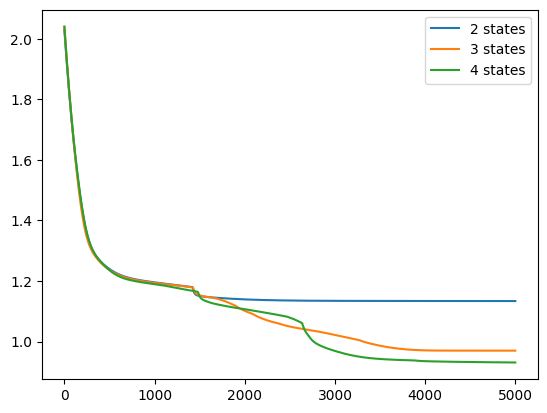

In [17]:
sns.lineplot(training_cache["CircHMM"][2].lps, label="2 states")
sns.lineplot(training_cache["CircHMM"][3].lps, label="3 states")
sns.lineplot(training_cache["CircHMM"][4].lps, label="4 states")

In [18]:
training_cache

Array([2.0404584, 2.0360305, 2.031616 , ..., 0.9309583, 0.9309559,
       0.9309536], dtype=float32)

In [19]:
training_cache["CircHMM"][4]

In [23]:
training_cache["CircHMM"][4].fit_params.transitions.transition_weights[0]

Array([[-0.23085745,  0.37730235,  0.28121665,  0.97430235,  1.4713405 ],
       [-0.7254634 ,  0.72348994, -0.45906   , -0.7803172 , -0.57019705],
       [-1.577803  , -1.6051687 , -1.6427596 , -1.6031122 , -1.6805452 ],
       [ 0.65423036, -1.2755809 ,  0.24850003, -0.21454309, -1.2671362 ]],      dtype=float32)

In [26]:
training_cache["CircHMM"][4].fit_params.emissions.weights

Array([[[ 2.83266187e-01,  1.07381800e-02, -6.40832484e-02,
          4.37593684e-02,  1.10763276e+00]],

       [[ 1.17694043e-01, -8.89237896e-02, -6.21083975e-02,
         -2.06562668e-01,  1.74767315e+00]],

       [[ 1.09972075e-01,  2.89706793e-02,  2.14026291e-02,
          1.42162833e-02,  6.28260374e-01]],

       [[ 3.66456471e-02,  2.39577387e-02,  8.37263884e-04,
          1.31549640e-02,  2.25558829e+00]]], dtype=float32)

In [27]:
training_cache["CircHMM"][4].fit_params.emissions.covs

Array([[[ 4.9348955]],

       [[ 1.9043467]],

       [[ 5.4074445]],

       [[40.73532  ]]], dtype=float32)

In [36]:
training_cache["CircHMM"][4].fit_model.emission_component.distribution(training_cache["CircHMM"][4].fit_params.emissions, 2)

TypeError: unsupported operand type(s) for @: 'ArrayImpl' and 'NoneType'